<h1>Fundamentos</h1>

In [1]:
%pylab inline
from sklearn import discriminant_analysis, linear_model, neighbors
from matplotlib import colors
from random import randint
from scipy import stats
from scipy.integrate import dblquad

Populating the interactive namespace from numpy and matplotlib


<h2>Generacion Datos</h2>
<p>Los datos se generan como en el <a href="http://finiterank.github.io/TESL/tresmodelos.html">ejemplo en R</a>: Para cada color primero se generan 10 centroides de una distribución normal con media $media_{color}$ y matriz de covarianza $I$. Luego, para generar cada punto se escoge un centroide aleatoriamente y se usa éste como media de una distribución normal con varianza $I/5$.</p>

In [2]:
matriz_cov_centroides = [[1, 0], [0, 1]]
matriz_cov_puntos = [[1/5, 0], [0, 1/5]]
media_azul = [1, 0]
media_naranja = [0, 1]

In [3]:
def generar_observaciones(centroides, sigma, numero):
    coords_x, coords_y = np.zeros(numero), np.zeros(numero)
    for i in range(numero):
        media = centroides[randint(0,len(centroides))-1]
        coords_x[i], coords_y[i] = random.multivariate_normal(media, sigma, 1).T
    return coords_x, coords_y
def generar_poblaciones(numero, centroides_azules, centroides_naranjas):
    etiquetas_azules = ['blue' for x in range(numero)]
    etiquetas_naranjas = ['orange' for x in range(numero)]
    
    etiquetas_azules_num = [0 for x in range(numero)]
    etiquetas_naranjas_num = [1 for x in range(numero)]
    
    puntos_azules = column_stack((generar_observaciones(centroides_azules, matriz_cov_puntos, numero)))
    puntos_azules = column_stack((puntos_azules, etiquetas_azules, etiquetas_azules_num))
    
    puntos_naranjas = column_stack((generar_observaciones(centroides_naranjas, matriz_cov_puntos, numero)))
    puntos_naranjas = column_stack((puntos_naranjas, etiquetas_naranjas, etiquetas_naranjas_num))
    
    return puntos_azules, puntos_naranjas

In [37]:
centroides_azules = column_stack((random.multivariate_normal(media_azul, matriz_cov_centroides, 10).T))
centroides_naranjas = column_stack((random.multivariate_normal(media_naranja, matriz_cov_centroides, 10).T))
puntos_azules_entrenamiento, puntos_naranjas_entrenamiento = generar_poblaciones(100, centroides_azules, centroides_naranjas)
puntos_entrenamiento = concatenate([puntos_azules_entrenamiento, puntos_naranjas_entrenamiento])
puntos_azules_prueba, puntos_naranjas_prueba = generar_poblaciones(5000, centroides_azules, centroides_naranjas)
puntos_prueba = concatenate([puntos_azules_prueba, puntos_naranjas_prueba])

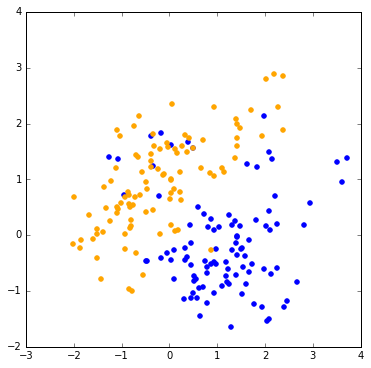

In [38]:
figsize(6, 6)
scatter(puntos_azules_entrenamiento[:,0], puntos_azules_entrenamiento[:,1], color='blue')
scatter(puntos_naranjas_entrenamiento[:,0], puntos_naranjas_entrenamiento[:,1], color='orange')

In [39]:
#Funciones auxiliares para graficar resultados de modelos
def encontrar_limites(puntos):
    x_min = puntos[:, 0].astype(np.float).min() - 1
    x_max = puntos[:, 0].astype(np.float).max() + 1
    y_min = puntos[:, 1].astype(np.float).min() - 1
    y_max = puntos[:, 1].astype(np.float).max() + 1
    return x_min, x_max, y_min, y_max
def dar_mapa_colores():
    return colors.ListedColormap(['#99bdff', '#ffe4b2'])

<h2>Regresión Lineal</h2>

In [40]:
lr = linear_model.LinearRegression()
lr_model = lr.fit(puntos_entrenamiento[:,(0,1)].astype(np.float), puntos_entrenamiento[:,3].astype(np.float))

In [41]:
x_lr_coef = lr_model.coef_[0]
y_lr_coef = lr_model.coef_[1]
free_lr_coef = lr_model.intercept_

lr_slope = -x_lr_coef/y_lr_coef;
lr_intercept = (0.5 - free_lr_coef)/y_lr_coef

(-2.6523639639450263, 3.8873853310239719)

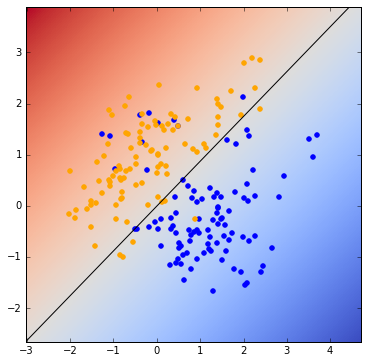

In [42]:
figsize(6, 6)
x_min, x_max, y_min, y_max = encontrar_limites(puntos_entrenamiento)
x_lin = linspace(x_min, x_max)
separador =  [lr_slope*float(x) + lr_intercept for x in x_lin]

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400), np.linspace(y_min, y_max, 400))
z = lr_model.predict(np.c_[xx.ravel(), yy.ravel()])[:].reshape(xx.shape)
pcolormesh(xx, yy, z, cmap='coolwarm')

scatter(puntos_azules_entrenamiento[:,0], puntos_azules_entrenamiento[:,1], color='blue')
scatter(puntos_naranjas_entrenamiento[:,0], puntos_naranjas_entrenamiento[:,1], color='orange')
plot(x_lin, separador, color='k', marker='')
xlim([x_min,x_max])
ylim([y_min,y_max])

<h3>Error del Modelo</h3>

In [43]:
#Funcion auxiliar para calculos de error
def predecir_error(puntos_azules, puntos_naranjas, modelo):
    etiquetas_predichas_puntos_azules = modelo.predict(puntos_azules.astype(np.float))
    azules_falsos = sum([x >= 0.5 for x in etiquetas_predichas_puntos_azules])

    etiquetas_predichas_puntos_naranjas = modelo.predict(puntos_naranjas.astype(np.float))
    naranjas_falsos = sum([x < 0.5 for x in etiquetas_predichas_puntos_naranjas])

    error = (azules_falsos + naranjas_falsos)/(len(puntos_azules)+len(puntos_naranjas))
    return error

In [44]:
error_entrenamiento_lr = predecir_error(
    puntos_azules_entrenamiento[:,(0,1)], puntos_naranjas_entrenamiento[:,(0,1)], lr_model)
error_prueba_lr = predecir_error(
    puntos_azules_prueba[:,(0,1)], puntos_naranjas_prueba[:,(0,1)], lr_model)
print('Error en el Conjunto de Entrenamiento: {0:.2f}%'.format(error_entrenamiento_lr*100))
print('Error en el Conjunto de Prueba: {0:.2f}%'.format(error_prueba_lr*100))

Error en el Conjunto de Entrenamiento: 9.00%
Error en el Conjunto de Prueba: 13.78%


<h2>K Vecinos (15 vecinos)</h2>

In [45]:
n_neighbors = 15
knc15 = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform") 
knc15_model = knc15.fit(puntos_entrenamiento[:,(0,1)].astype(np.float), puntos_entrenamiento[:,3].astype(np.float))

(-2.6523639639450263, 3.8873853310239719)

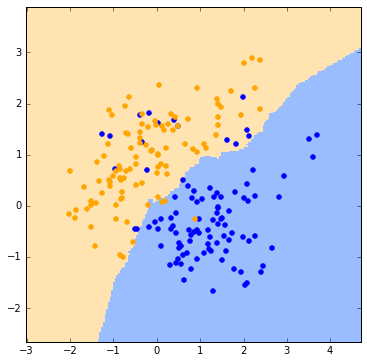

In [46]:
figsize(6, 6)
x_min, x_max, y_min, y_max = encontrar_limites(puntos_entrenamiento)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
z = knc15_model.predict(np.c_[xx.ravel(), yy.ravel()])[:].reshape(xx.shape)
pcolormesh(xx, yy, z, cmap=dar_mapa_colores())

scatter(puntos_azules_entrenamiento[:,0], puntos_azules_entrenamiento[:,1], color='blue')
scatter(puntos_naranjas_entrenamiento[:,0], puntos_naranjas_entrenamiento[:,1], color='orange')
xlim([x_min,x_max])
ylim([y_min,y_max])

<h3>Error del Modelo</h3>

In [47]:
error_entrenamiento = predecir_error(
    puntos_azules_entrenamiento[:,(0,1)], puntos_naranjas_entrenamiento[:,(0,1)], knc15_model)
error_prueba = predecir_error(
    puntos_azules_prueba[:,(0,1)], puntos_naranjas_prueba[:,(0,1)], knc15_model)
print('Error en el Conjunto de Entrenamiento: {0:.2f}%'.format(error_entrenamiento*100))
print('Error en el Conjunto de Prueba: {0:.2f}%'.format(error_prueba*100))

Error en el Conjunto de Entrenamiento: 10.50%
Error en el Conjunto de Prueba: 14.97%


<h2>K Vecinos (1 vecino)</h2>

In [48]:
n_neighbors = 1
knc1 = neighbors.KNeighborsClassifier(n_neighbors, weights="uniform") 
knc1_model = knc1.fit(puntos_entrenamiento[:,(0,1)].astype(np.float), puntos_entrenamiento[:,3].astype(np.float))

(-2.6523639639450263, 3.8873853310239719)

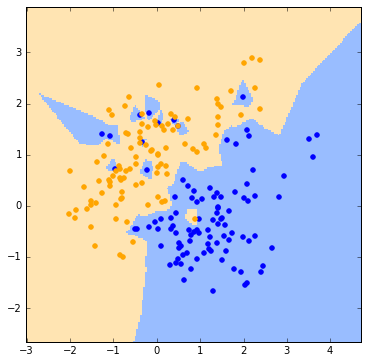

In [49]:
figsize(6, 6)
x_min, x_max, y_min, y_max = encontrar_limites(puntos_entrenamiento)
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
z = knc1_model.predict(np.c_[xx.ravel(), yy.ravel()])[:].reshape(xx.shape)
pcolormesh(xx, yy, z, cmap=dar_mapa_colores())

scatter(puntos_azules_entrenamiento[:,0], puntos_azules_entrenamiento[:,1], color='blue')
scatter(puntos_naranjas_entrenamiento[:,0], puntos_naranjas_entrenamiento[:,1], color='orange')
xlim([x_min,x_max])
ylim([y_min,y_max])

<h3>Error del Modelo</h3>

In [50]:
error_entrenamiento = predecir_error(
    puntos_azules_entrenamiento[:,(0,1)], puntos_naranjas_entrenamiento[:,(0,1)], knc1_model)
error_prueba = predecir_error(
    puntos_azules_prueba[:,(0,1)], puntos_naranjas_prueba[:,(0,1)], knc1_model)
print('Error en el Conjunto de Entrenamiento: {0:.2f}%'.format(error_entrenamiento*100)) #Debe ser cero!
print('Error en el Conjunto de Prueba: {0:.2f}%'.format(error_prueba*100))

Error en el Conjunto de Entrenamiento: 0.00%
Error en el Conjunto de Prueba: 19.49%


<h2>Variacion de Errores</h2>

In [51]:
error_entrenamiento_nn = []
error_prueba_nn = []
grados_libertad_nn = []
grados_libertad_lr = 3
bayes = 0
for k in range(200):
    knc = neighbors.KNeighborsClassifier(200-k, weights="uniform") 
    knc_model = knc.fit(puntos_entrenamiento[:,(0,1)].astype(np.float), puntos_entrenamiento[:,3].astype(np.float))
    
    error = predecir_error(puntos_azules_entrenamiento[:,(0,1)], puntos_naranjas_entrenamiento[:,(0,1)], knc_model)
    error_entrenamiento_nn.append(error)
    
    error = predecir_error(puntos_azules_prueba[:,(0,1)], puntos_naranjas_prueba[:,(0,1)], knc_model)
    error_prueba_nn.append(error)
    
    grados_libertad_nn.append(200/(200-k))    

In [52]:
#Funciones auxiliares para el calculo del error optimo de Bayes tal y como se describe en el ejemplo en R, en la 
#seccion "Aproximación ideal: el mejor modelo de todos"
def probabilidad_azul(punto):
    probs = []
    for centroide_azul in centroides_azules:
        probs.append(stats.multivariate_normal.pdf(punto, mean=centroide_azul, cov=0.2))
    return mean(probs)
def probabilidad_naranja(punto):
    probs = []
    for centroide_naranja in centroides_naranjas:
        probs.append(stats.multivariate_normal.pdf(punto, mean=centroide_naranja, cov=0.2))
    return mean(probs)
def densidad_error(x, y):
    punto = [x,y]
    p_azul = probabilidad_azul(punto)
    p_naranja = probabilidad_naranja(punto)
    if p_azul < p_naranja:
        return p_azul
    else:
        return p_naranja

In [54]:
#Calcular el error optimo de Bayes puede demorar mas de 30 minutos, correr solo si se piensa ir por un cafe
#La idea seria poder integarr de -50 a 50 (numeros mas grandes), pero la integral nunca terminaba
bayes = dblquad(densidad_error, -5, 5, lambda x: -5, lambda x: 5)[0]
bayes = 0.5*bayes
print(bayes)

0.14405249973141562


(0, 0.5)

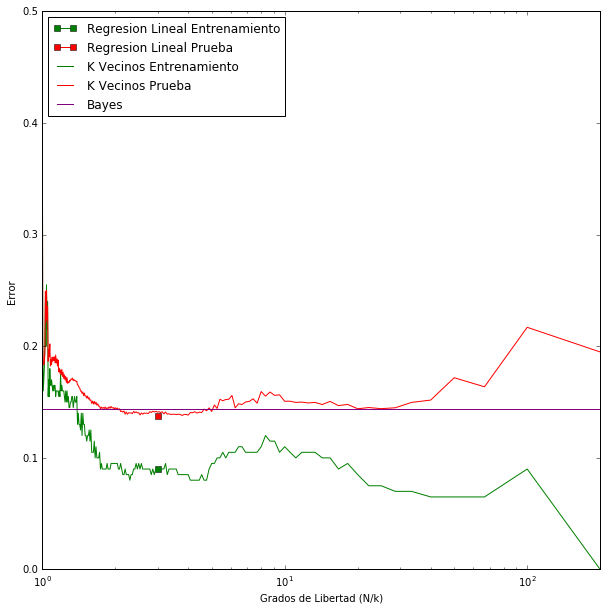

In [57]:
figsize(10, 10)
bayes_optimum = [bayes for x in grados_libertad_nn]
plot(grados_libertad_lr, error_entrenamiento_lr, marker='s', color='green')
plot(grados_libertad_lr, error_prueba_lr, marker='s', color='red')
semilogx(grados_libertad_nn, error_entrenamiento_nn, marker='', color='green')
semilogx(grados_libertad_nn, error_prueba_nn, marker='', color='red')
semilogx(grados_libertad_nn, bayes_optimum, marker='', color='purple')
xlabel('Grados de Libertad (N/k)')
ylabel('Error')
plt.legend(
    ['Regresion Lineal Entrenamiento', 'Regresion Lineal Prueba', 'K Vecinos Entrenamiento', 'K Vecinos Prueba', 'Bayes'], 
    loc='upper left')
xlim([1,200])
ylim([0,max(error_prueba_nn)])